In [1]:
import autoplier.model as ap
import autoplier.plot as plot
import csv
import h5py
import json
import matplotlib.pyplot as plt
import mygene
import numpy as np
from onto_lib import general_ontology_tools as got
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\anaconda3\envs\autoplierpubanalysis\lib\site-packages\onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autoplierpubanalysis\lib\site-packages\onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autoplierpubanalysis\lib\site-packages\onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autoplierpubanalysis\lib\site-packages\onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autoplierpubanalysis\lib\site-packages\onto_lib\obo\EFO.17-01-30.obo ...


In [2]:
pathway_genes = []
pathway_names = []

with open('data/c2.all.v7.5.1.entrez.gmt', newline='\n') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        pathway_names += [row[0]]
        pathway_genes += [row[2:]]

with open("data/bulk_labels.json", 'r') as f:
    labels = json.load(f)

In [3]:
with open('data/validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open('data/pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [4]:
mlb = MultiLabelBinarizer()
pathways = pd.DataFrame(mlb.fit_transform(pathway_genes), index = pathway_names, columns = mlb.classes_)

In [5]:
mg = mygene.MyGeneInfo()
genes = pathways.columns.tolist()
info = mg.getgenes(genes, fields="ensembl")

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-21728...done.


In [6]:
not_in_db = []
rename = {}
for x in info:
    if("ensembl" in x):
        y = x["ensembl"]
        if(type(y) == list):
            y = y[0]
        rename[x["query"]] = y["gene"]
    else:
        not_in_db += [x["query"]]

In [7]:
pathways = pathways.drop(columns = not_in_db)
pathways = pathways.rename(columns=rename)

In [8]:
pathways = pathways.groupby(level = 0, axis = 1).first()

In [9]:
pathways

,126231,55872,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,...,ENSG00000288702,ENSG00000288705,ENSG00000288722,ENSG00000288825,ENSG00000288859,ENSG00000288905,ENSG00000288907,ENSG00000288920,ENSG00000289048,ENSG00000289313
CORONEL_RFX7_DIRECT_TARGETS_UP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOROUTAN_TGFB_EMT_UP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOROUTAN_TGFB_EMT_DN,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
FOROUTAN_PRODRANK_TGFB_EMT_UP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOROUTAN_PRODRANK_TGFB_EMT_DN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SA_MMP_CYTOKINE_CONNECTION,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SA_PROGRAMMED_CELL_DEATH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SA_PTEN_PATHWAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SA_REG_CASCADE_OF_CYCLIN_EXPR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
hf = h5py.File('data/bulk_log_tpm.h5', 'r')
experiment = hf.get('experiment')[()].astype(str)
expression = hf.get('expression')[()].astype(float)
gene_id = hf.get('gene_id')[()].astype(str)

CellO_data = pd.DataFrame(expression, index = experiment, columns = gene_id)

In [11]:
CellO_data

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000284739,ENSG00000284740,ENSG00000284741,ENSG00000284742,ENSG00000284743,ENSG00000284744,ENSG00000284745,ENSG00000284746,ENSG00000284747,ENSG00000284748
SRX890545,0.071963,0.068414,3.718085,2.184815,1.490935,6.995514,0.629519,3.892468,3.241940,2.960884,...,0.0,0.247113,0.0,0.0,0.000000,0.254355,0.0,0.000000e+00,0.418459,0.105734
SRX1067711,0.033104,0.000000,3.743323,1.990195,1.780348,6.565519,0.045174,3.519702,3.266680,2.425106,...,0.0,1.319242,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.589718,0.087458
SRX1067710,0.233484,0.000000,3.376271,1.523096,0.611052,5.667817,0.013306,3.271395,3.490619,2.419673,...,0.0,0.176014,0.0,0.0,0.000000,0.108282,0.0,9.637153e-08,0.337275,0.153931
SRX762971,0.000000,0.000000,0.270898,0.272666,0.046180,4.310495,0.048563,0.505901,1.021726,0.468655,...,0.0,0.000000,0.0,0.0,0.000000,0.098300,0.0,0.000000e+00,0.161494,0.063805
SRX762970,0.000000,0.000000,0.000000,0.153331,0.029985,3.570165,0.012488,0.376561,0.298916,0.148210,...,0.0,0.124347,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.124297,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX3399308,0.900313,0.000000,4.034299,2.548069,1.914284,6.135145,1.561809,3.504841,2.099581,2.509156,...,0.0,0.551206,0.0,0.0,0.000000,0.784501,0.0,0.000000e+00,0.644274,0.084220
SRX3399309,0.317015,0.000000,3.972622,2.634532,2.009371,6.394950,1.277340,3.693114,2.188385,2.900505,...,0.0,0.000000,0.0,0.0,0.000000,0.596177,0.0,0.000000e+00,0.681857,0.204546
SRX3399310,0.799190,0.000000,4.109202,2.661645,2.445280,6.295505,1.314905,3.792382,1.471354,3.156924,...,0.0,0.000000,0.0,0.0,0.223545,0.152269,0.0,0.000000e+00,0.962468,0.265818
SRX3399311,0.044163,0.000000,4.007751,2.015217,1.989733,6.363111,0.788769,3.855940,2.337722,3.061316,...,0.0,0.000000,0.0,0.0,0.000000,0.269960,0.0,0.000000e+00,0.465199,0.145112


In [12]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=100, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

In [13]:
sample2types_full = {
        sample: list(map(got.get_term_name, types_ids))
        for sample, types_ids in labels.items()
    }
mlb_full = MultiLabelBinarizer()

types_per_samples = CellO_data.index.map(sample2types_full).values
samples_dummies = pd.DataFrame(mlb_full.fit_transform(types_per_samples), columns=mlb_full.classes_,
                                      index=CellO_data.index)

celltypes = samples_dummies.columns.tolist()

type2samples = {
    type_: samples_dummies.index[samples_dummies[type_] == 1].tolist()
    for type_ in celltypes
}
types_sizes = samples_dummies.sum()
types_with_data = types_sizes.index.values
all_types = samples_dummies.columns

In [24]:
# fscore metric used to evaluate classifiers
def fscore(p, r):
    denom = p + r or 1

    return 2*(p * r) / denom

In [93]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
def analyze_PCA(celltype1, celltype2, pathways, seed, split_size, milestone):

    data_c1 = samples_dummies[celltype1][samples_dummies[celltype1] == 1].sample(n = split_size, random_state= seed)
    data_c2 = samples_dummies[celltype2][samples_dummies[celltype2] == 1].sample(n = split_size, random_state= seed)
    overlap_1 = ~data_c1.index.isin(data_c2.index)
    overlap_2 = ~data_c2.index.isin(data_c1.index)
    data_c1 = data_c1[overlap_1]
    data_c2 = data_c2[overlap_2]
    
    
    X = CellO_data[CellO_data.index.isin(data_c1.index.union(data_c2.index))]
    X = X[X.columns[X.columns.isin(pathways.columns)]]
    pathways1 = pathways[pathways.columns[pathways.columns.isin(X.columns)]]

    scaler = preprocessing.StandardScaler()

    X_tilde = np.dot(X, pathways1.T.to_numpy())

    X_tilde = scaler.fit_transform(X_tilde)
                   
                   
    pca = PCA(random_state = seed) #do not define number of PCs

    X_pca = pca.fit_transform(X_tilde)
    
    # compute total variation explained
    totvar = sum(pca.explained_variance_)
    cum_var = np.cumsum(pca.explained_variance_)/totvar
    print(len(cum_var))
    for i, val in enumerate(cum_var):
        
        if(val >= milestone):
            print(i)
            Z, model = train_autoplier(X, pathways, seed, i*6)

            Z_train = Z[Z.index.isin(train_egs)]
            Z_test = Z[Z.index.isin(validation_egs)]

            y_train = samples_dummies[samples_dummies.index.isin(Z_train.index)]
            y_test = samples_dummies[samples_dummies.index.isin(Z_test.index)]

            f, ap = train_classifiers(y_train, y_test, Z_train, Z_test)
            return(i,val,f, ap)

In [77]:
def train_autoplier(X, pathways, seed, n_LVs):
    ap.set_seed_(seed)
    model = ap.autoPLIER(n_LVs, regval = 1.20E-7,learning_rate= 0.000156)
    model.fit(X, pathways, verbose=0, batch_size = None, callbacks = callbacks)
    Z = model.transform(X, pathways)
    
    print(ap.sparsity_epsilon(model.components_decomposition_, 1.0E-4))
    
    return Z, model

In [94]:
split_size = [10,50,100,150]
cum_vars_BT = []
dimensions = []
explained_var = []
fs = []
aps = []
for split in split_size:
    Dims,val,f_, ap_ = analyze_PCA("B cell", "T cell", pathways, 111, split, 0.95)
    explained_var += [val]
    fs += [f_]
    aps += [ap_]
    dimensions += [Dims]

20
7
0.6147016142303607
100
17
0.6920835566397467
200
21
0.7987971814550514
298
22
0.9411587600795895


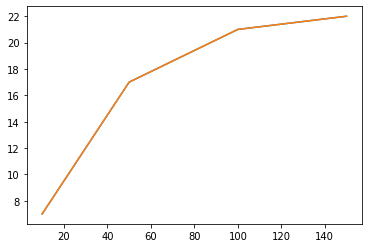

In [85]:
#plt.plot(split_size, dimensions)
plt.plot(split_size, dimensions)
plt.plot(split_size, dimensions)

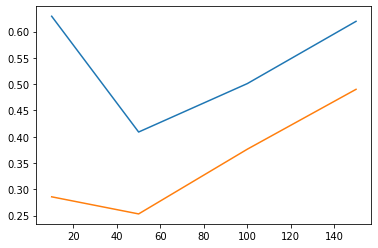

In [86]:
plt.plot(split_size, aps)
plt.plot(split_size, fs)

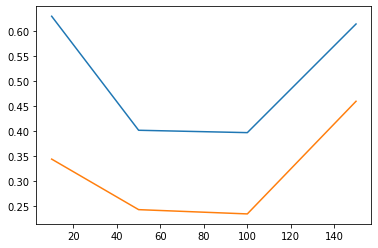

In [89]:
plt.plot(split_size, aps)
plt.plot(split_size, fs)

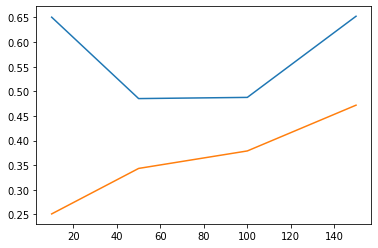

In [92]:
plt.plot(split_size, aps)
plt.plot(split_size, fs)

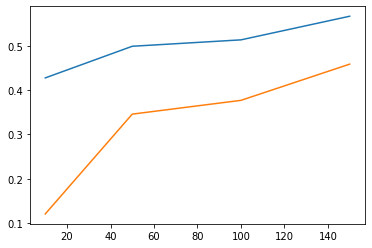

In [95]:
plt.plot(split_size, aps)
plt.plot(split_size, fs)

In [146]:
data_c1 = samples_dummies["B cell"][samples_dummies["B cell"] == 1]
data_c2 = samples_dummies["T cell"][samples_dummies["T cell"] == 1]
overlap_1 = ~data_c1.index.isin(data_c2.index)
overlap_2 = ~data_c2.index.isin(data_c1.index)
data_c1 = data_c1[overlap_1]
data_c2 = data_c2[overlap_2]
    
fs = []
aps = []
X = CellO_data[CellO_data.index.isin(data_c1.index.union(data_c2.index))]
X = X[X.columns[X.columns.isin(pathways.columns)]]
for LV in range(10, 40,5):
    Z, model = train_autoplier(X, pathways, 111, LV)
    
    Z_train = Z[Z.index.isin(train_egs)]
    Z_test = Z[Z.index.isin(validation_egs)]

    y_train = samples_dummies[samples_dummies.index.isin(Z_train.index)]
    y_test = samples_dummies[samples_dummies.index.isin(Z_test.index)]

    f, ap_ = train_classifiers(y_train, y_test, Z_train, Z_test)
    fs += [f]
    aps += [ap_]

0.9758718190386428
0.9858309770656614
0.9887684574300974
0.9919132893496702
0.9934338674206723
0.9925182891252636


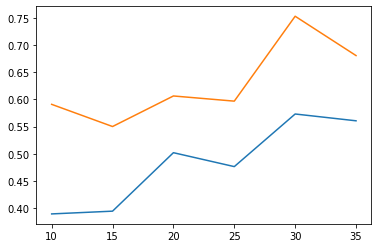

In [147]:
#plt.plot(split_size, dimensions)
plt.plot(range(10, 40,5), fs)
plt.plot(range(10, 40,5), aps)

In [149]:
data_c1 = samples_dummies["B cell"][samples_dummies["B cell"] == 1]
data_c2 = samples_dummies["T cell"][samples_dummies["T cell"] == 1]
overlap_1 = ~data_c1.index.isin(data_c2.index)
overlap_2 = ~data_c2.index.isin(data_c1.index)
data_c1 = data_c1[overlap_1]
data_c2 = data_c2[overlap_2]
    
    
X = CellO_data[CellO_data.index.isin(data_c1.index.union(data_c2.index))]
X = X[X.columns[X.columns.isin(pathways.columns)]]
pathways1 = pathways[pathways.columns[pathways.columns.isin(X.columns)]]

scaler = preprocessing.StandardScaler()

X_tilde = np.dot(X, pathways1.T.to_numpy())

X_tilde = scaler.fit_transform(X_tilde)
                   
                   
pca = PCA(random_state = 111) #do not define number of PCs

X_pca = pca.fit_transform(X_tilde)
    
# compute total variation explained
totvar = sum(pca.explained_variance_)
cum_var = np.cumsum(pca.explained_variance_)/totvar

In [152]:
cum_var[10]

0.9043611396793104

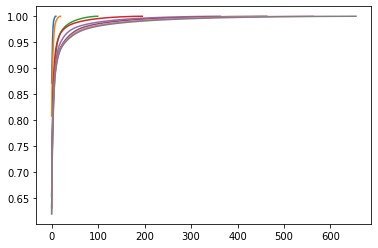

In [83]:
import matplotlib.pyplot as plt

for var in cum_vars:
    plt.plot(var)

In [22]:
def train_autoplier(X, pathways, seed, n_LVs):
    ap.set_seed_(seed)
    model = ap.autoPLIER(n_LVs, regval = 1.20E-7,learning_rate= 0.000156)
    model.fit(X, pathways, verbose=0, batch_size = None, callbacks = callbacks)
    Z = model.transform(X, pathways)
    
    print(ap.sparsity_epsilon(model.components_decomposition_, 1.0E-4))
    
    return Z, model

In [21]:
import warnings
warnings.filterwarnings("ignore")


def train_classifiers(train_target_full, test_target_full, train_data, test_data):
    
    test_precision = []
    test_recall = []
    aps = []
    fscores = []
    successful_celltypes = []
    unsuccessful_celltypes = []
    for cell_type in all_types:
        #print(cell_type)
        train_target = train_target_full[str(cell_type)]
        test_target = test_target_full[cell_type]

        if(1 in train_target.values and 1 in test_target.values and 0 in train_target.values and 0 in test_target.values):
        # lasso penalty

            
            PARAMETERS = {
            'C': [
            0.001, 
            0.01, 
            0.1, 
            1.0,
            10.0,
            100.0
            ]
            }
            MAX_ITER = 200000

            lr_model = LogisticRegression(penalty='l1', solver='liblinear')

            clf = GridSearchCV(lr_model, PARAMETERS, scoring='f1')
            
            clf.fit(train_data, train_target)

            best_params = max(
            zip(
                clf.cv_results_['param_C'], 
                clf.cv_results_['mean_test_score']
            ),
            key=lambda x: x[1]
            )
            best_C = best_params[0]
            #print("Best C chosen: ", best_C)
            
            lr_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter = 1000)
            lr_model.fit(train_data, train_target)
            
            
            target_pred = lr_model.predict(test_data)
            target_probs = lr_model.predict_proba(test_data)[:,1]
            test_pr = average_precision_score(test_target, target_probs)
            test_precision += [precision_score(test_target, target_pred)]
            test_recall += [recall_score(test_target, target_pred)]
            aps += [average_precision_score(test_target, target_probs)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]

            successful_celltypes += [cell_type]
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f= np.mean(fscores)
    f_micro = fscore(p, r) 
    ap = np.mean(aps)
    return(f, ap)

In [41]:
def compare_number_LVs(LVs):
    fs = []
    aps = []
    for LV in LVs:
    
        Z, model = train_autoplier(CellO_data, pathways, 111, LV)

        Z_train = Z[Z.index.isin(train_egs)]
        Z_test = Z[Z.index.isin(validation_egs)]

        y_train = samples_dummies[samples_dummies.index.isin(Z_train.index)]
        y_test = samples_dummies[samples_dummies.index.isin(Z_test.index)]
        
        f, ap = train_classifiers(y_train, y_test, Z_train, Z_test)
        print(LV, f, ap)
        fs += [f]
        aps += [ap]
    return fs, aps

In [46]:
lvrange = [2,4,8,10,50,100,200,300, 400, 500]

fs, aps = compare_number_LVs(lvrange)

0.7846371347785108
2 0.05427476990600457 0.08811311235207175
0.9758089852340559
4 0.0993083767343009 0.18748378595428322
0.9727262016965127
8 0.1913094674587878 0.25371743089873144
0.9907477222745837
10 0.22381370882211463 0.3089678939392335
0.9941658812441093
50 0.40651336463685167 0.5665269602546332
0.9945067546339931
100 0.46068476158061017 0.5973724841080373
0.9929343386742068
200 0.4937327417584072 0.6526363600882704
0.988992041051419
300 0.5086891041747923 0.6735934987786075
0.9883883129123469
400 0.48821748344609966 0.6364660961393781
0.9815975494816211
500 0.5117603256397522 0.6752774843294124
